In [1]:
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from darts import TimeSeries
from darts.models import NHiTSModel
from darts.utils.likelihood_models import GaussianLikelihood
from sklearn.preprocessing import MinMaxScaler
from darts.dataprocessing.transformers import Scaler
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl

user_smoothed = pd.read_csv("smoothed-user-service.csv")
product_smoothed = pd.read_csv("smoothed-product-service.csv")
order_smoothed = pd.read_csv("smoothed-order-service.csv")
reviews_smoothed = pd.read_csv("smoothed-reviews-service.csv")
payment_smoothed = pd.read_csv("smoothed-payment-service.csv")
shipping_smoothed = pd.read_csv("smoothed-shipping-service.csv")

/home/shahzaibshaikh/deep-learning-research/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


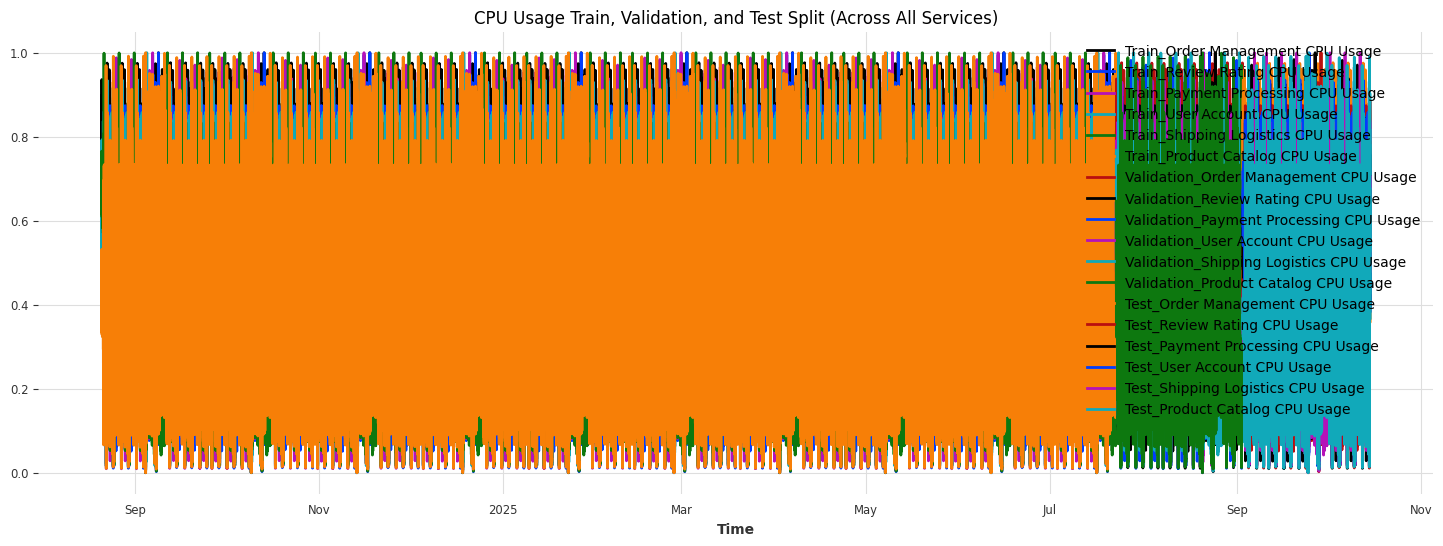

/home/shahzaibshaikh/deep-learning-research/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


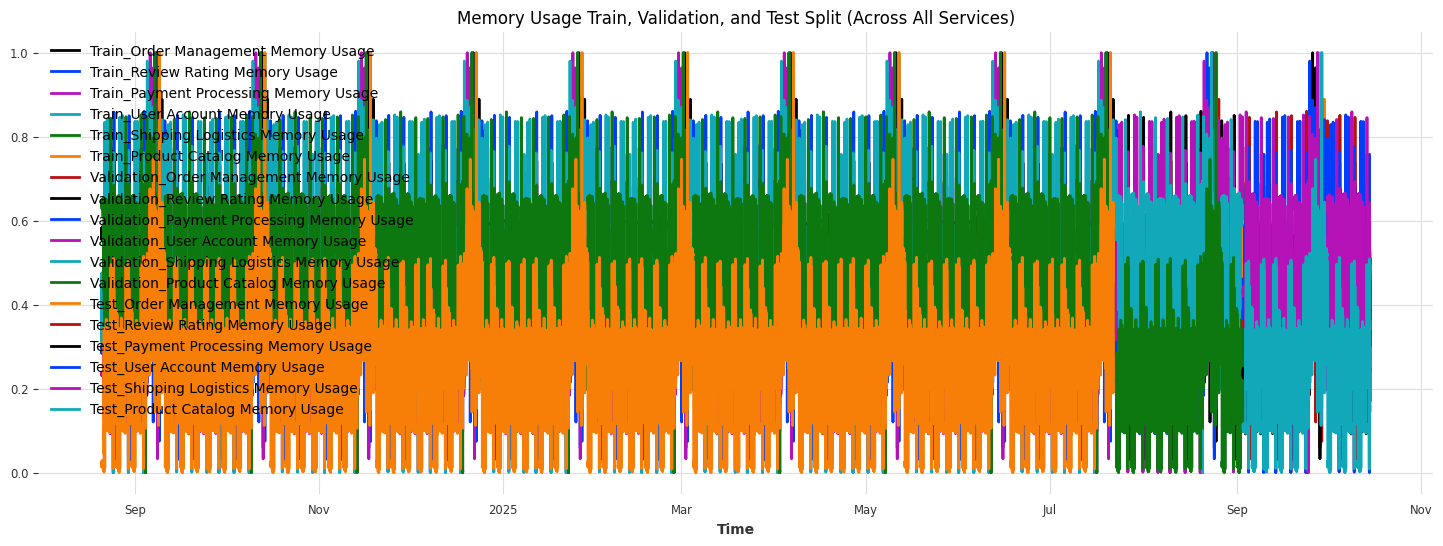

/home/shahzaibshaikh/deep-learning-research/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


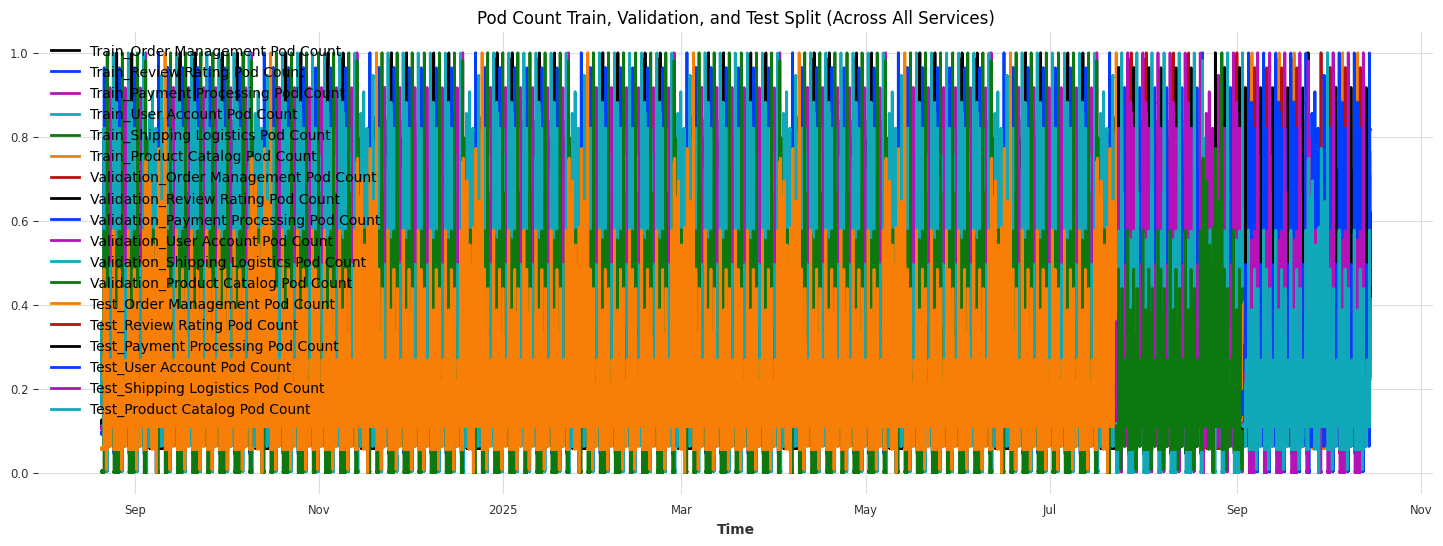

/home/shahzaibshaikh/deep-learning-research/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


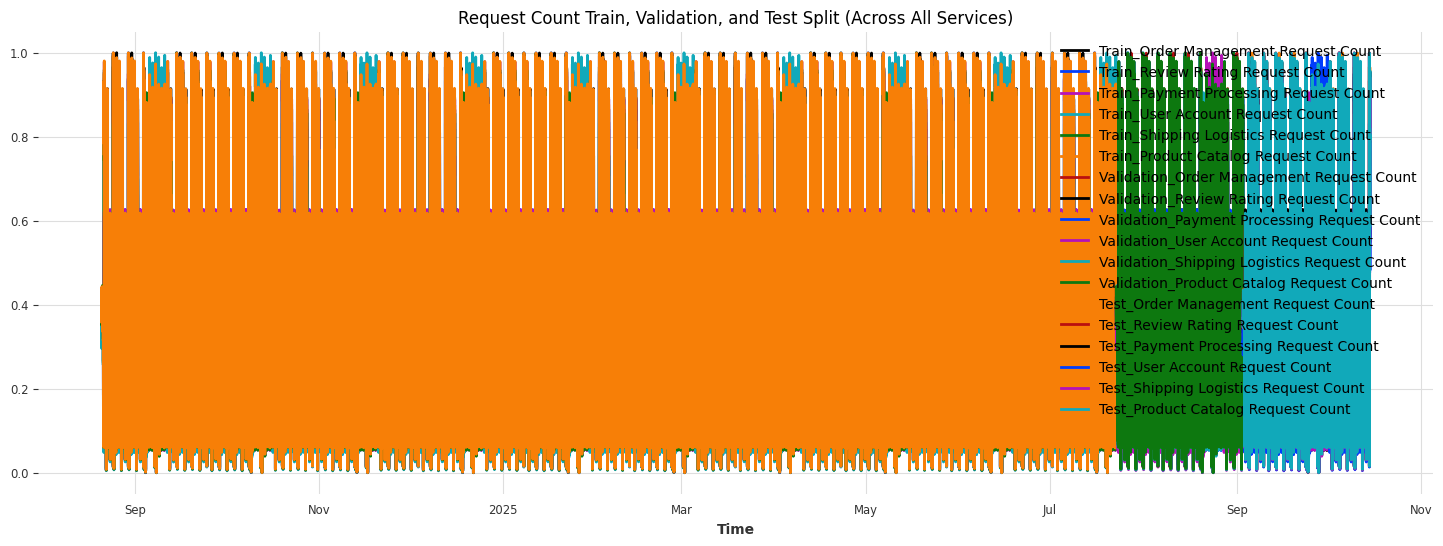

/home/shahzaibshaikh/deep-learning-research/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


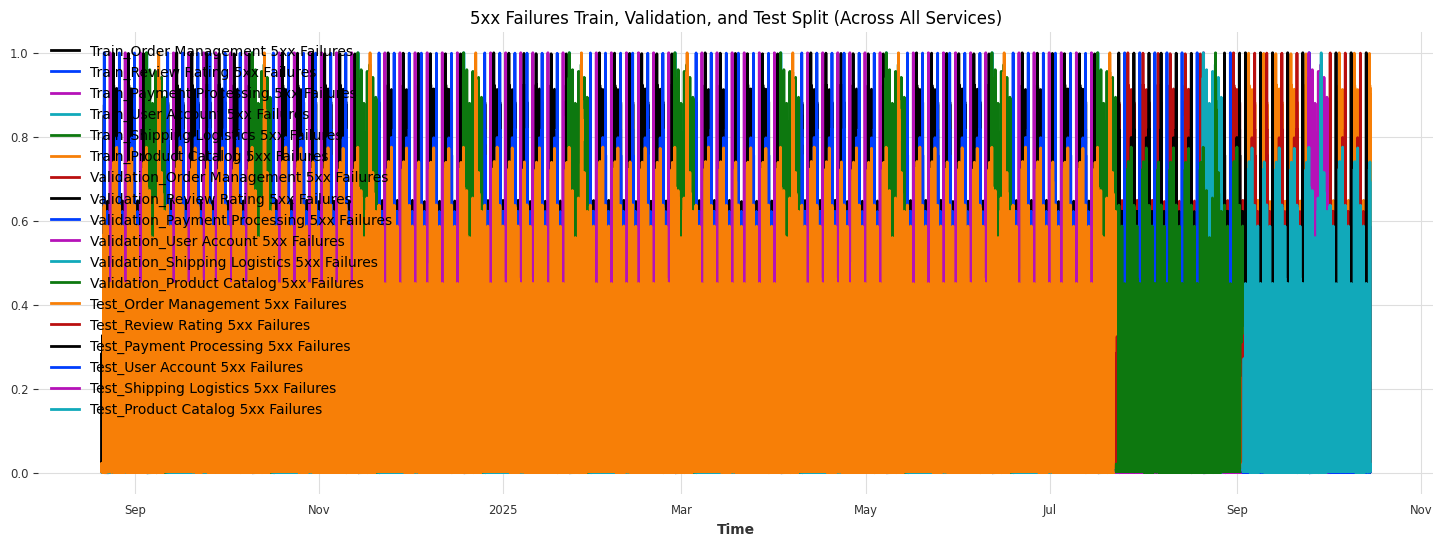

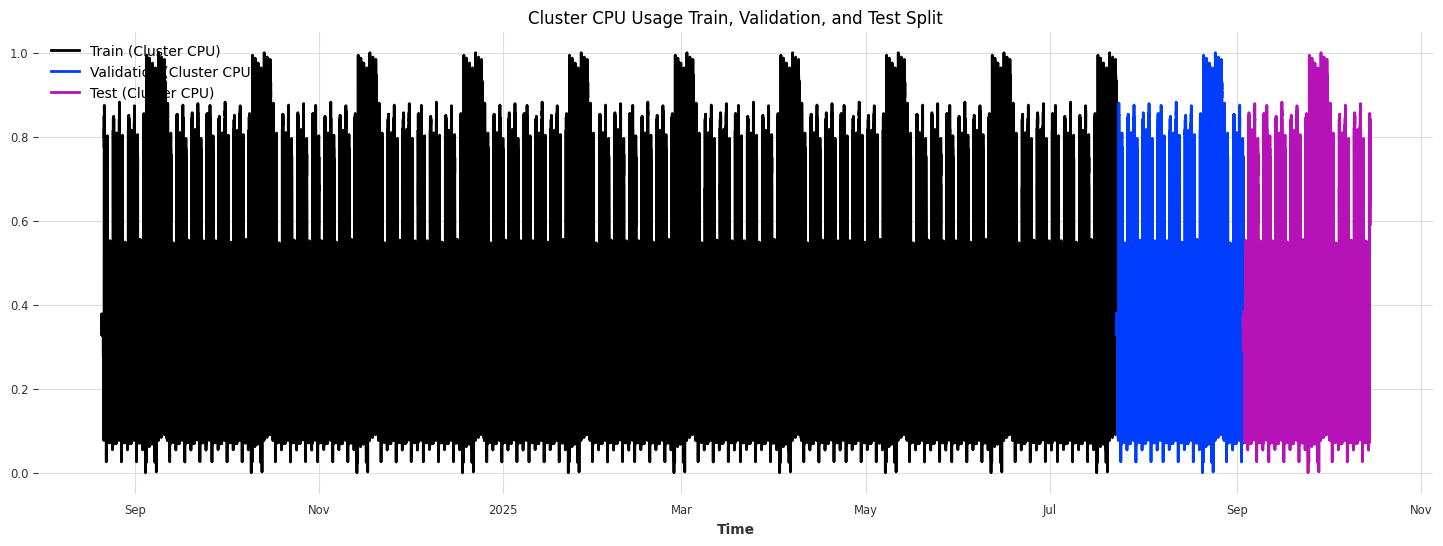

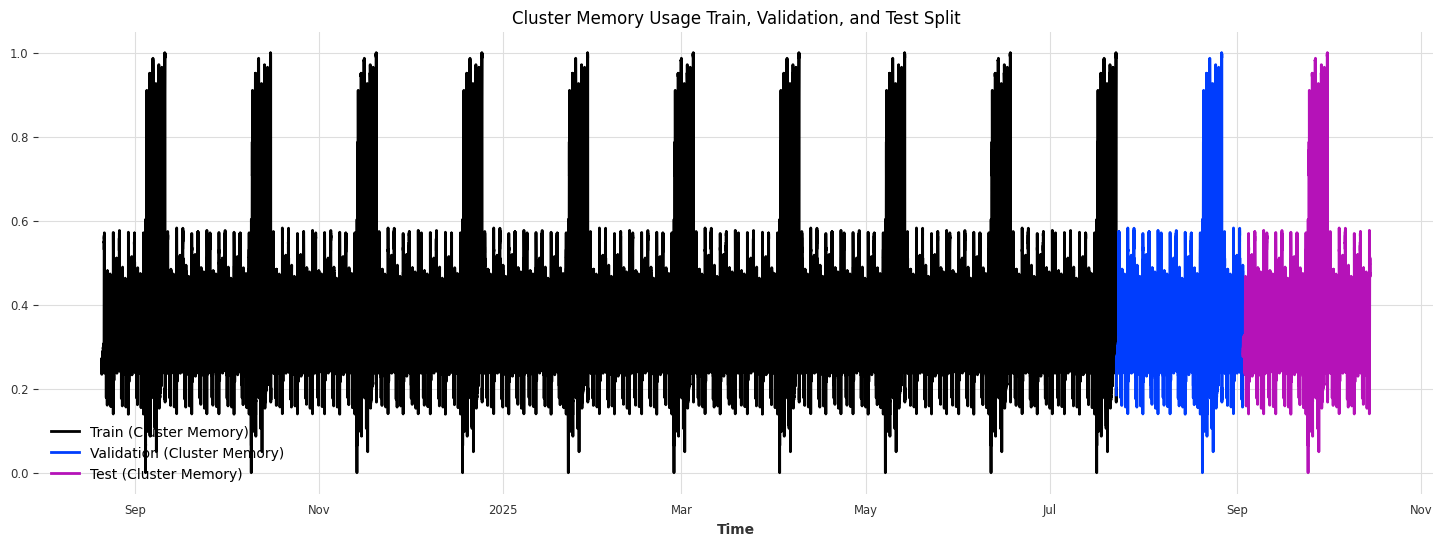

In [2]:
train_size = 0.8  # 80% of the data for training
val_size = 0.1   # 10% of the data for validation
test_size = 0.1  # 10% of the data for testing

### 1. Service-Level Features (Specific to each Services)

# 1. CPU Usage (Across all services)
series_order_cpu = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management CPU Usage')
series_review_cpu = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating CPU Usage')
series_payment_cpu = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing CPU Usage')
series_user_cpu = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account CPU Usage')
series_shipping_cpu = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics CPU Usage')
series_product_cpu = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog CPU Usage')

# Stack all services' CPU usage into one feature-centric time series
series_cpu_all_services = (
    series_order_cpu.stack(series_review_cpu)
    .stack(series_payment_cpu)
    .stack(series_user_cpu)
    .stack(series_shipping_cpu)
    .stack(series_product_cpu)
)

# Normalize/Scale the data for CPU usage
scaler_cpu = Scaler(MinMaxScaler())
series_cpu_all_services_scaled = scaler_cpu.fit_transform(series_cpu_all_services)

# Train/Test/Validation Split for CPU usage
train_val_cutoff_cpu = int(train_size * len(series_cpu_all_services_scaled))
val_test_cutoff_cpu = int((train_size + val_size) * len(series_cpu_all_services_scaled))

train_series_cpu = series_cpu_all_services_scaled[:train_val_cutoff_cpu]
val_series_cpu = series_cpu_all_services_scaled[train_val_cutoff_cpu:val_test_cutoff_cpu]
test_series_cpu = series_cpu_all_services_scaled[val_test_cutoff_cpu:]

plt.figure(figsize=(18, 6))
train_series_cpu.plot(label='Train')
val_series_cpu.plot(label='Validation')
test_series_cpu.plot(label='Test')
plt.title("CPU Usage Train, Validation, and Test Split (Across All Services)")
plt.legend()
plt.show()


# 2. Memory Usage (Across all services)
series_order_memory = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management Memory Usage')
series_review_memory = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating Memory Usage')
series_payment_memory = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing Memory Usage')
series_user_memory = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account Memory Usage')
series_shipping_memory = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics Memory Usage')
series_product_memory = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog Memory Usage')

# Stack all services' memory usage into one feature-centric time series
series_memory_all_services = (
    series_order_memory.stack(series_review_memory)
    .stack(series_payment_memory)
    .stack(series_user_memory)
    .stack(series_shipping_memory)
    .stack(series_product_memory)
)

# Normalize/Scale the data for Memory usage
scaler_memory = Scaler(MinMaxScaler())
series_memory_all_services_scaled = scaler_memory.fit_transform(series_memory_all_services)

# Train/Test/Validation Split for Memory usage
train_val_cutoff_memory = int(train_size * len(series_memory_all_services_scaled))
val_test_cutoff_memory = int((train_size + val_size) * len(series_memory_all_services_scaled))

train_series_memory = series_memory_all_services_scaled[:train_val_cutoff_memory]
val_series_memory = series_memory_all_services_scaled[train_val_cutoff_memory:val_test_cutoff_memory]
test_series_memory = series_memory_all_services_scaled[val_test_cutoff_memory:]

plt.figure(figsize=(18, 6))
train_series_memory.plot(label='Train')
val_series_memory.plot(label='Validation')
test_series_memory.plot(label='Test')
plt.title("Memory Usage Train, Validation, and Test Split (Across All Services)")
plt.legend()
plt.show()


# 3. Pod Count (Across all services)
series_order_pod_count = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management Pod Count')
series_review_pod_count = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating Pod Count')
series_payment_pod_count = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing Pod Count')
series_user_pod_count = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account Pod Count')
series_shipping_pod_count = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics Pod Count')
series_product_pod_count = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog Pod Count')

# Stack all services' pod count into one feature-centric time series
series_pod_count_all_services = (
    series_order_pod_count.stack(series_review_pod_count)
    .stack(series_payment_pod_count)
    .stack(series_user_pod_count)
    .stack(series_shipping_pod_count)
    .stack(series_product_pod_count)
)

# Normalize/Scale the data for Pod Count
scaler_pod_count = Scaler(MinMaxScaler())
series_pod_count_all_services_scaled = scaler_pod_count.fit_transform(series_pod_count_all_services)

# Train/Test/Validation Split for Pod Count
train_val_cutoff_pod_count = int(train_size * len(series_pod_count_all_services_scaled))
val_test_cutoff_pod_count = int((train_size + val_size) * len(series_pod_count_all_services_scaled))

train_series_pod_count = series_pod_count_all_services_scaled[:train_val_cutoff_pod_count]
val_series_pod_count = series_pod_count_all_services_scaled[train_val_cutoff_pod_count:val_test_cutoff_pod_count]
test_series_pod_count = series_pod_count_all_services_scaled[val_test_cutoff_pod_count:]

plt.figure(figsize=(18, 6))
train_series_pod_count.plot(label='Train')
val_series_pod_count.plot(label='Validation')
test_series_pod_count.plot(label='Test')
plt.title("Pod Count Train, Validation, and Test Split (Across All Services)")
plt.legend()
plt.show()


# 4. Request Count (Across all services)
series_order_request_count = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management Request Count')
series_review_request_count = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating Request Count')
series_payment_request_count = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing Request Count')
series_user_request_count = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account Request Count')
series_shipping_request_count = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics Request Count')
series_product_request_count = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog Request Count')

# Stack all services' request count into one feature-centric time series
series_request_count_all_services = (
    series_order_request_count.stack(series_review_request_count)
    .stack(series_payment_request_count)
    .stack(series_user_request_count)
    .stack(series_shipping_request_count)
    .stack(series_product_request_count)
)

# Normalize/Scale the data for Request Count
scaler_request_count = Scaler(MinMaxScaler())
series_request_count_all_services_scaled = scaler_request_count.fit_transform(series_request_count_all_services)

# Train/Test/Validation Split for Request Count
train_val_cutoff_request_count = int(train_size * len(series_request_count_all_services_scaled))
val_test_cutoff_request_count = int((train_size + val_size) * len(series_request_count_all_services_scaled))

train_series_request_count = series_request_count_all_services_scaled[:train_val_cutoff_request_count]
val_series_request_count = series_request_count_all_services_scaled[train_val_cutoff_request_count:val_test_cutoff_request_count]
test_series_request_count = series_request_count_all_services_scaled[val_test_cutoff_request_count:]

plt.figure(figsize=(18, 6))
train_series_request_count.plot(label='Train')
val_series_request_count.plot(label='Validation')
test_series_request_count.plot(label='Test')
plt.title("Request Count Train, Validation, and Test Split (Across All Services)")
plt.legend()
plt.show()


# 5. 5xx Failures (Across all services)
series_order_5xx_failures = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management 5xx Failures')
series_review_5xx_failures = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating 5xx Failures')
series_payment_5xx_failures = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing 5xx Failures')
series_user_5xx_failures = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account 5xx Failures')
series_shipping_5xx_failures = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics 5xx Failures')
series_product_5xx_failures = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog 5xx Failures')

# Stack all services' 5xx failures into one feature-centric time series
series_5xx_failures_all_services = (
    series_order_5xx_failures.stack(series_review_5xx_failures)
    .stack(series_payment_5xx_failures)
    .stack(series_user_5xx_failures)
    .stack(series_shipping_5xx_failures)
    .stack(series_product_5xx_failures)
)

# Normalize/Scale the data for 5xx Failures
scaler_5xx_failures = Scaler(MinMaxScaler())
series_5xx_failures_all_services_scaled = scaler_5xx_failures.fit_transform(series_5xx_failures_all_services)

# Train/Test/Validation Split for 5xx Failures
train_val_cutoff_5xx_failures = int(train_size * len(series_5xx_failures_all_services_scaled))
val_test_cutoff_5xx_failures = int((train_size + val_size) * len(series_5xx_failures_all_services_scaled))

train_series_5xx_failures = series_5xx_failures_all_services_scaled[:train_val_cutoff_5xx_failures]
val_series_5xx_failures = series_5xx_failures_all_services_scaled[train_val_cutoff_5xx_failures:val_test_cutoff_5xx_failures]
test_series_5xx_failures = series_5xx_failures_all_services_scaled[val_test_cutoff_5xx_failures:]

plt.figure(figsize=(18, 6))
train_series_5xx_failures.plot(label='Train')
val_series_5xx_failures.plot(label='Validation')
test_series_5xx_failures.plot(label='Test')
plt.title("5xx Failures Train, Validation, and Test Split (Across All Services)")
plt.legend()
plt.show()


### 2. Cluster-Level Features (Common to All Services)

# Fetch Cluster CPU and Memory from Order Management data (since it's common across all services)
series_cluster_cpu = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Cluster CPU')
series_cluster_memory = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Cluster Memory')

# Normalize/Scale the data for Cluster CPU and Memory
scaler_cluster_cpu = Scaler(MinMaxScaler())
scaler_cluster_memory = Scaler(MinMaxScaler())

series_cluster_cpu_scaled = scaler_cluster_cpu.fit_transform(series_cluster_cpu)
series_cluster_memory_scaled = scaler_cluster_memory.fit_transform(series_cluster_memory)

# Train/Test/Validation Split for Cluster CPU
train_val_cutoff_cluster_cpu = int(train_size * len(series_cluster_cpu_scaled))
val_test_cutoff_cluster_cpu = int((train_size + val_size) * len(series_cluster_cpu_scaled))

train_series_cluster_cpu = series_cluster_cpu_scaled[:train_val_cutoff_cluster_cpu]
val_series_cluster_cpu = series_cluster_cpu_scaled[train_val_cutoff_cluster_cpu:val_test_cutoff_cluster_cpu]
test_series_cluster_cpu = series_cluster_cpu_scaled[val_test_cutoff_cluster_cpu:]

# Train/Test/Validation Split for Cluster Memory
train_val_cutoff_cluster_memory = int(train_size * len(series_cluster_memory_scaled))
val_test_cutoff_cluster_memory = int((train_size + val_size) * len(series_cluster_memory_scaled))

train_series_cluster_memory = series_cluster_memory_scaled[:train_val_cutoff_cluster_memory]
val_series_cluster_memory = series_cluster_memory_scaled[train_val_cutoff_cluster_memory:val_test_cutoff_cluster_memory]
test_series_cluster_memory = series_cluster_memory_scaled[val_test_cutoff_cluster_memory:]

# Plot Cluster CPU and Memory Splits
plt.figure(figsize=(18, 6))
train_series_cluster_cpu.plot(label='Train (Cluster CPU)')
val_series_cluster_cpu.plot(label='Validation (Cluster CPU)')
test_series_cluster_cpu.plot(label='Test (Cluster CPU)')
plt.title("Cluster CPU Usage Train, Validation, and Test Split")
plt.legend()
plt.show()

plt.figure(figsize=(18, 6))
train_series_cluster_memory.plot(label='Train (Cluster Memory)')
val_series_cluster_memory.plot(label='Validation (Cluster Memory)')
test_series_cluster_memory.plot(label='Test (Cluster Memory)')
plt.title("Cluster Memory Usage Train, Validation, and Test Split")
plt.legend()
plt.show()


In [3]:
import os
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from darts.models import NHiTSModel, TiDEModel
from darts.utils.likelihood_models import GaussianLikelihood
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pytorch_lightning as pl

# Define model arguments for the feature-centric approach
nhits_model_args = {
    "input_chunk_length": 2880,  # Past 24 hours time steps as input
    "output_chunk_length": 480,  # Predict the next 8 hours time steps
    "n_epochs": 30,
    "random_state": 42, 
    "num_stacks": 10, # previously 7
    "num_layers": 6, # previously 4
    "likelihood": GaussianLikelihood(),  
    "batch_size": 128, # previously 64
    "lr_scheduler_cls": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "lr_scheduler_kwargs": {"factor": 0.5, "patience": 5},
    "save_checkpoints": True,
    "force_reset": True,
    "dropout": 0.25, # previously 0.2
    "optimizer_kwargs": {"lr": 1e-3}  # Define your learning rate here
}

# Early stopping configuration
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 3,
    "mode": "min",
    "strict": True,
    "verbose": True,
}

# Define log directory
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

# Create a TensorBoard logger
logger = TensorBoardLogger(log_dir, name="feature_centric_all_models")

# Trainer configuration
pl_trainer_kwargs = {
    "max_epochs": 30,
    "logger": logger
}

# Directory where models will be saved
model_dir = os.path.expanduser("~/Documents/models/")
os.makedirs(model_dir, exist_ok=True)  # Create the directory if it doesn't exist


/home/shahzaibshaikh/deep-learning-research/lib/python3.12/site-packages/darts/models/forecasting/torch_forecasting_model.py:1747: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature

Predicting: |                                                                       | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/shahzaibshaikh/deep-learning-research/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                                                       | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/shahzaibshaikh/deep-learning-research/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                                                       | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/shahzaibshaikh/deep-learning-research/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                                                       | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/shahzaibshaikh/deep-learning-research/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                                                       | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/shahzaibshaikh/deep-learning-research/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                                                       | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/shahzaibshaikh/deep-learning-research/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                                                       | 0/? [00:00<?, ?it/s]

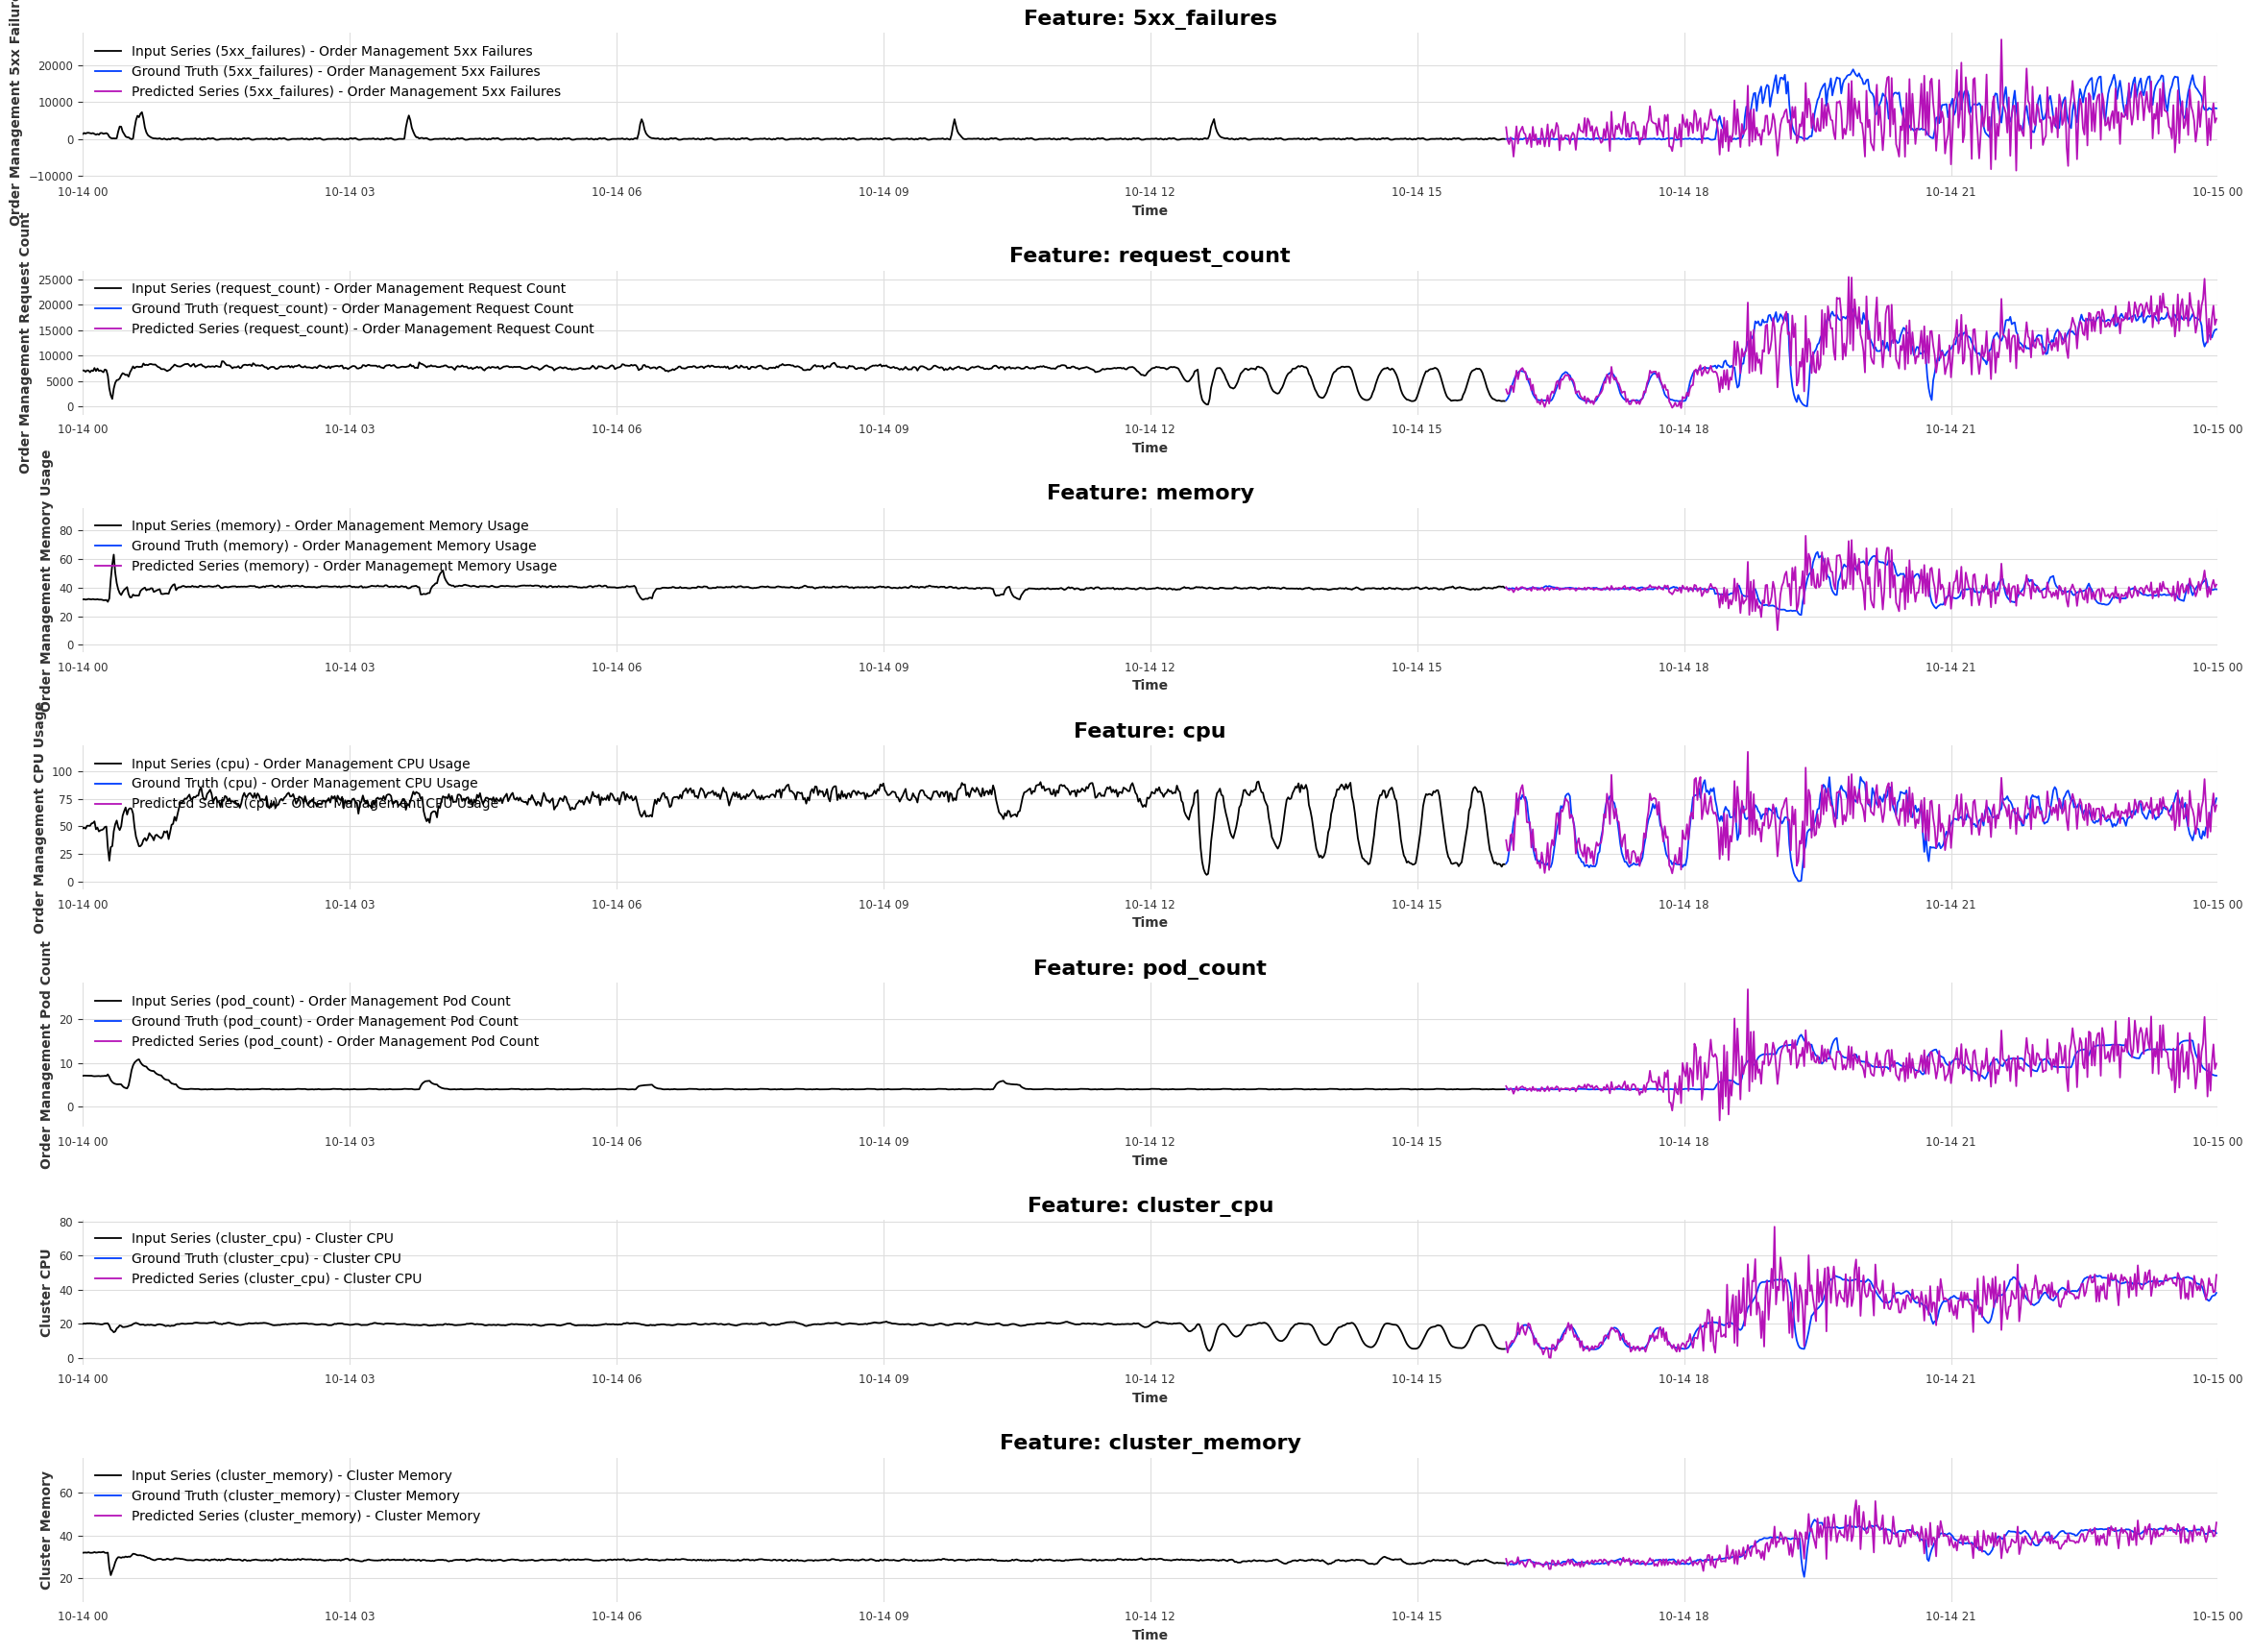

In [5]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from darts.models import NHiTSModel
import numpy as np
import pandas as pd
from datetime import datetime
from pykalman import KalmanFilter

# Directory where the models are saved
model_dir = os.path.expanduser("~/Documents/models/")

# Prediction steps
pred_steps = 480

# Define the prediction date range
start_date = datetime(2025, 10, 14)
end_date = datetime(2025, 10, 15)

# Prepare a dictionary for models based on your feature-centric approach
models_dict = {
    "5xx_failures": NHiTSModel.load(os.path.join(model_dir, "5xx_failures_model.pt")),
    "request_count": NHiTSModel.load(os.path.join(model_dir, "request_count_model.pt")),
    "memory": NHiTSModel.load(os.path.join(model_dir, "memory_model.pt")),
    "cpu": NHiTSModel.load(os.path.join(model_dir, "cpu_model.pt")),
    "pod_count": NHiTSModel.load(os.path.join(model_dir, "pod_count_model.pt")),
    "cluster_cpu": NHiTSModel.load(os.path.join(model_dir, "cluster_cpu_model.pt")),
    "cluster_memory": NHiTSModel.load(os.path.join(model_dir, "cluster_memory_model.pt")),
}

# Prepare a dictionary for input and ground truth series
test_series_dict = {
    "5xx_failures": test_series_5xx_failures,
    "request_count": test_series_request_count,
    "memory": test_series_memory,
    "cpu": test_series_cpu,
    "pod_count": test_series_pod_count,
    "cluster_cpu": test_series_cluster_cpu,
    "cluster_memory": test_series_cluster_memory,
}

# Explicit mapping of feature names to their corresponding column names in your data
column_name_mapping = {
    "5xx_failures": [
        "Order Management 5xx Failures",
        # "Review Rating 5xx Failures",
        # "Payment Processing 5xx Failures",
        # "User Account 5xx Failures",
        # "Shipping Logistics 5xx Failures",
        # "Product Catalog 5xx Failures"
    ],
    "request_count": [
        "Order Management Request Count",
        # "Review Rating Request Count",
        # "Payment Processing Request Count",
        # "User Account Request Count",
        # "Shipping Logistics Request Count",
        # "Product Catalog Request Count"
    ],
    "memory": [
        "Order Management Memory Usage",
        # "Review Rating Memory Usage",
        # "Payment Processing Memory Usage",
        # "User Account Memory Usage",
        # "Shipping Logistics Memory Usage",
        # "Product Catalog Memory Usage"
    ],
    "cpu": [
        "Order Management CPU Usage",
        # "Review Rating CPU Usage",
        # "Payment Processing CPU Usage",
        # "User Account CPU Usage",
        # "Shipping Logistics CPU Usage",
        # "Product Catalog CPU Usage"
    ],
    "pod_count": [
        "Order Management Pod Count",
        # "Review Rating Pod Count",
        # "Payment Processing Pod Count",
        # "User Account Pod Count",
        # "Shipping Logistics Pod Count",
        # "Product Catalog Pod Count"
    ],
    "cluster_cpu": [
        "Cluster CPU"
    ],
    "cluster_memory": [
        "Cluster Memory"
    ]
}

# Create a 7x1 subplot to visualize the series
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(24, 18))
fig.tight_layout(pad=5.0)

# Define a dictionary for scalers
scalers_dict = {
    "5xx_failures": scaler_5xx_failures,
    "request_count": scaler_request_count,
    "memory": scaler_memory,
    "cpu": scaler_cpu,
    "pod_count": scaler_pod_count,
    "cluster_cpu": scaler_cluster_cpu,
    "cluster_memory": scaler_cluster_memory,
}

kf_params = {
    "5xx_failures": {"initial_state_covariance": 0.3, "transition_covariance": 0.5, "observation_covariance": 0.2},
    "request_count": {"initial_state_covariance": 0.2, "transition_covariance": 0.1, "observation_covariance": 0.5},
    "memory": {"initial_state_covariance": 0.3, "transition_covariance": 0.3, "observation_covariance": 0.2},
    "cpu": {"initial_state_covariance": 0.2, "transition_covariance": 0.3, "observation_covariance": 0.5},
    "pod_count": {"initial_state_covariance": 0.3, "transition_covariance": 0.3, "observation_covariance": 0.3},
    "cluster_cpu": {"initial_state_covariance": 0.2, "transition_covariance": 0.1, "observation_covariance": 0.5},
    "cluster_memory": {"initial_state_covariance": 0.2, "transition_covariance": 0.1, "observation_covariance": 0.5},
}


# Create a dictionary to store separate DataFrames for each service
service_dataframes = {}

# Loop through each feature and perform predictions
for idx, (feature_name, model) in enumerate(models_dict.items()):
    # Prepare the input and ground truth series
    pred_input = test_series_dict[feature_name][:-pred_steps]  # Input data for prediction
    ground_truth = test_series_dict[feature_name][-pred_steps:]  # Actual future data

    # Get the appropriate scaler for this feature
    scaler = scalers_dict[feature_name]
    
    # Predict the next `pred_steps` points
    pred_series = model.predict(n=pred_steps, series=pred_input)

    # Inverse transform the series to get actual values
    input_series = scaler.inverse_transform(pred_input).pd_dataframe()
    ground_series = scaler.inverse_transform(ground_truth).pd_dataframe()
    predicted_series = scaler.inverse_transform(pred_series).pd_dataframe()

    params = kf_params[feature_name]
    
    kf = KalmanFilter(
        initial_state_mean=predicted_series.mean(axis=0).values,
        n_dim_state=predicted_series.shape[1],
        n_dim_obs=predicted_series.shape[1],
        initial_state_covariance=np.eye(predicted_series.shape[1]) * params["initial_state_covariance"],
        transition_matrices=np.eye(predicted_series.shape[1]),
        observation_matrices=np.eye(predicted_series.shape[1]),
        transition_covariance=np.eye(predicted_series.shape[1]) * params["transition_covariance"],
        observation_covariance=np.eye(predicted_series.shape[1]) * params["observation_covariance"]
    )

    kf = kf.em(predicted_series.values, n_iter=10)
    (filtered_state_means, _) = kf.filter(predicted_series.values)

    # Convert filtered results back to DataFrame for easier plotting
    filtered_series = pd.DataFrame(filtered_state_means, index=predicted_series.index, columns=predicted_series.columns)

    # Loop through all columns for this feature and plot each one
    for column in column_name_mapping[feature_name]:
        # Plotting the series and include the model name in the label
        sns.lineplot(ax=axes[idx], x=input_series.index, y=input_series[column], label=f'Input Series ({feature_name}) - {column}')
        sns.lineplot(ax=axes[idx], x=ground_series.index, y=ground_series[column], label=f'Ground Truth ({feature_name}) - {column}')
        sns.lineplot(ax=axes[idx], x=predicted_series.index, y=predicted_series[column], label=f'Predicted Series ({feature_name}) - {column}')
        # sns.lineplot(ax=axes[idx], x=filtered_series.index, y=filtered_series[column], label=f'Filtered Series ({feature_name}) - {column}')

    axes[idx].set_title(f"Feature: {feature_name}", fontsize=16, fontweight='bold')
    axes[idx].legend(loc='upper left')
    axes[idx].set_xlim(left=start_date, right=end_date)

    for column in column_name_mapping[feature_name]:
        service_name = column.split()[0]  # Get service name from the column name
        if service_name not in service_dataframes:
            service_dataframes[service_name] = pd.DataFrame(index=predicted_series.index)

        # Store predictions and ground truth
        service_dataframes[service_name][f"{column}"] = filtered_series[column]
        # service_dataframes[service_name][f"{column} Ground Truth"] = ground_series[column]


# Display the plot
# plt.savefig('Final Predictions with Kalman Filter.png')
plt.show()
